In [13]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# internal 
from dcgan import Generator, Discriminator, GANTrainer
from utils import weights_init, make_plot, get_real_images, get_fake_images, set_criterion, set_optimizer
from image_data import ImageData


In [2]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True


PyTorch version: 2.1.1+cu118
CUDA version: 11.8


# Image Data
Chose from the readily available datasets in torchvision.datasets.

In [20]:
data = ImageData()
datasets_list = data.get_datasets_list()
dataset_mnist = data.get_dataset(dataset_name='MNIST', root=DATA_PATH, download=True, transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))
dataset_mnist

ImageData class created


AttributeError: 'ImageData' object has no attribute 'get_dataset'

In [19]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))
print(dataset)

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

print(dataloader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


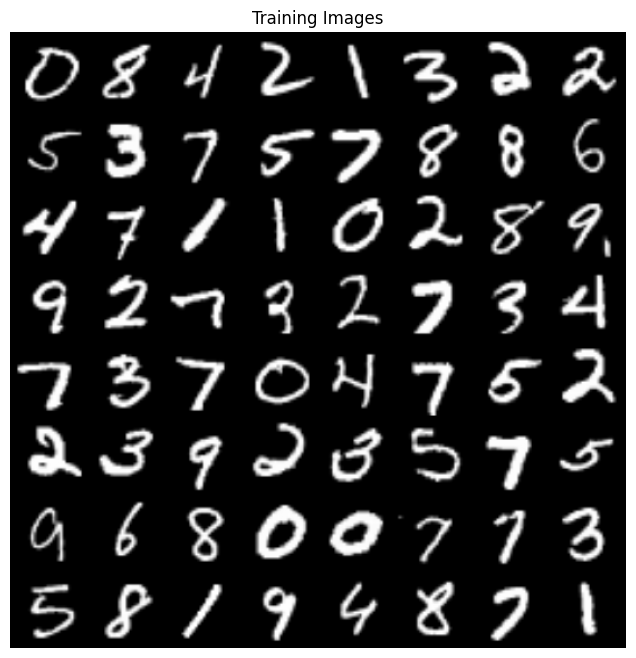

In [15]:
get_real_images(dataloader, device)


In [6]:
# Create the generator
netG = Generator(Z_DIM, G_HIDDEN, IMAGE_CHANNEL).to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator(IMAGE_CHANNEL, D_HIDDEN).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
# Initialize BCELoss function
criterion = set_criterion(criterion_name='BCE')

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = set_optimizer(optimizer_name='Adam', net=netD, lr=lr, betas=(0.5, 0.999))
optimizerG = set_optimizer(optimizer_name='Adam', net=netG, lr=lr, betas=(0.5, 0.999))

In [8]:

# Create an instance of GANTrainer
gan_trainer = GANTrainer(netG,
                         netD,
                         dataloader,
                         device,
                         EPOCH_NUM,
                         REAL_LABEL,
                         FAKE_LABEL,
                         Z_DIM,
                         optimizerG,
                         optimizerD,
                         criterion,
                         viz_noise
                         )

# Train the GAN
image_list, g_loss, d_loss = gan_trainer.train()


Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4453	Loss_G: 4.1402	D(x): 0.5697	D(G(z)): 0.4739 / 0.0247
[0/5][50/469]	Loss_D: 3.7130	Loss_G: 36.4918	D(x): 0.9997	D(G(z)): 0.9388 / 0.0000
[0/5][100/469]	Loss_D: 0.0007	Loss_G: 37.1727	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/5][150/469]	Loss_D: 0.0003	Loss_G: 36.6429	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/5][200/469]	Loss_D: 0.0000	Loss_G: 30.6610	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][250/469]	Loss_D: 0.2207	Loss_G: 4.9943	D(x): 0.9263	D(G(z)): 0.1221 / 0.0089
[0/5][300/469]	Loss_D: 0.3823	Loss_G: 3.4040	D(x): 0.8824	D(G(z)): 0.1935 / 0.0464
[0/5][350/469]	Loss_D: 0.2387	Loss_G: 4.7167	D(x): 0.9430	D(G(z)): 0.1504 / 0.0145
[0/5][400/469]	Loss_D: 3.5814	Loss_G: 4.3059	D(x): 0.9934	D(G(z)): 0.9471 / 0.0304
[0/5][450/469]	Loss_D: 0.2403	Loss_G: 4.0178	D(x): 0.9495	D(G(z)): 0.1604 / 0.0275
[1/5][0/469]	Loss_D: 0.2266	Loss_G: 3.4636	D(x): 0.9340	D(G(z)): 0.1385 / 0.0420
[1/5][50/469]	Loss_D: 0.3543	Loss_G: 1.8144	D(x): 0.7447	D(G(z

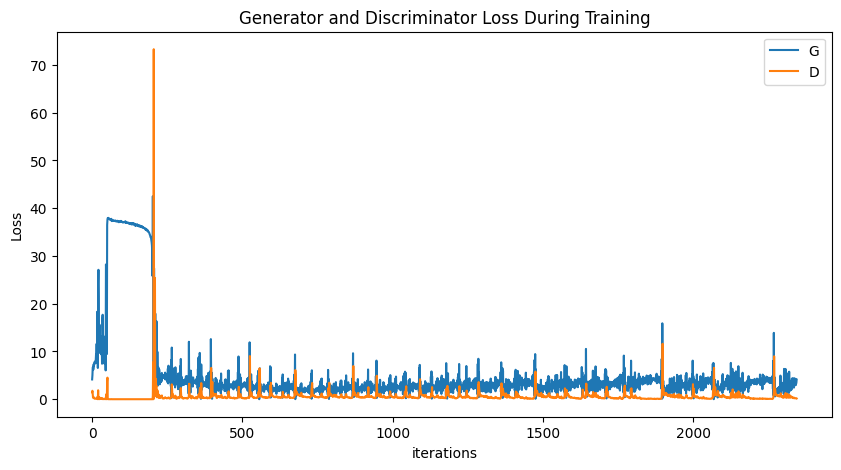

In [16]:
# Plot the training losses
make_plot(g_loss, d_loss)

In [10]:
image_list

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4934,  ..., 0.5030, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4599,  ..., 0.4839, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4934,  ..., 0.5030, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4599,  ..., 0.4839, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4934,  ...,

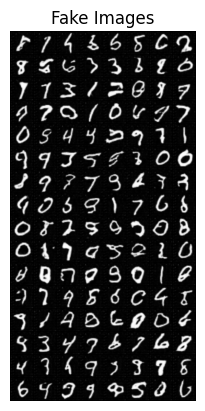

In [17]:
# Select a subset of images
subset_image_list = image_list[:10]

# Plot the fake images from the last epoch of the subset
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(subset_image_list[-1],(1,2,0)))
plt.show()

IndexError: list index out of range

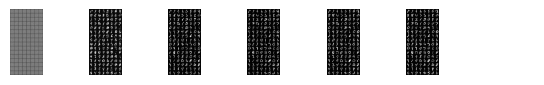

In [12]:
get_fake_images(image_list)